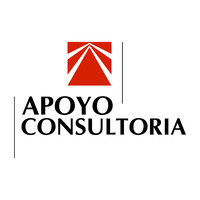
# Interpolacion

Esta libreria realiza la interpolacion del PBI a frecuencia mensual, la cual fue estimada en el modulo Kalman.

### Librerias y rutas

In [1]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos
from ipynb.fs.defs.Kalman import interpol
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
#Frecuencias de variables
frq1 = 3
frq2 = 1

In [3]:
rutaOrigen = 'inputs/'
rutaEstimacion = 'model_interpol/'
rutaDestino = 'resultados/'

### Importando base agregada

In [4]:
_,_,_,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Usuario\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
VariablesPBI = ['pbiNorteTrimestral_Trimestre_VariacionAnual',
                'pbiCentroTrimestral_Trimestre_VariacionAnual',
                'pbiSurTrimestral_Trimestre_VariacionAnual'
               ]
VariablesExogenas = list(set([x for x in bd_all.columns if 'Mensual_VariacionAnual' in x]) - set(VariablesPBI))

### Resultados de interpolacion

In [23]:
def kalman_resultados(model_input,bd_all,var,frq1,frq2,test_size):
    
    #Importando modelo
    
    bd_model = pd.read_excel(model_input,sheet_name = var[0:20], index_col = 0 )

    
    y = [var]
    X = bd_model.index[3:].tolist()
    
    NombreVariableFrecuencia1Filtrada = y[0][0:6] + '_VariacionFrecuencia1_Filtrada'
    NombreVariableFrecuencia2Filtrada = y[0][0:6] + '_VariacionFrecuencia2_Filtrada'

    NombreVariableFrecuencia1Imputada = y[0][0:6] + '_VariacionFrecuencia1_Imputada'
    NombreVariableFrecuencia2Imputada = y[0][0:6] + '_VariacionFrecuencia2_Imputada'
    
    ParametrosOptimizados = bd_model.Valor.values.tolist()
    
    _, KalmanInterpolador, BaseInterpolacion = interpol(bd_all,X,y,frq1,frq2,ParametrosOptimizados,test_size)
    
    BaseInterpolacion[NombreVariableFrecuencia1Filtrada] = pd.DataFrame(KalmanInterpolador.filter(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
    BaseInterpolacion[NombreVariableFrecuencia2Filtrada] = BaseInterpolacion[NombreVariableFrecuencia1Filtrada].rolling(int(frq1/frq2)).mean()
    BaseInterpolacion[NombreVariableFrecuencia1Imputada] = pd.DataFrame(KalmanInterpolador.smooth(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
    BaseInterpolacion[NombreVariableFrecuencia2Imputada] = BaseInterpolacion[NombreVariableFrecuencia1Imputada].rolling(int(frq1/frq2)).mean()
    
    baseResultados = BaseInterpolacion[[NombreVariableFrecuencia1Filtrada,NombreVariableFrecuencia2Filtrada,NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia2Imputada]]
    
    return BaseInterpolacion, KalmanInterpolador, baseResultados

### Interpolacion

In [25]:
baseFinal = pd.DataFrame()
for y in VariablesPBI:

    _,_,baseInterpolacion = kalman_resultados(rutaEstimacion + 'ModelosKalman.xlsx', bd_all, y, frq1, frq2,0)
    baseFinal = baseFinal.join(baseInterpolacion, how = 'outer')

In [26]:
with pd.ExcelWriter(rutaDestino + 'baseInterpolacion.xlsx') as writer:
    baseFinal.to_excel(writer, sheet_name = 'Interpol')

### Evaluacion

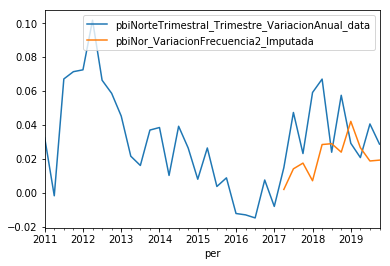

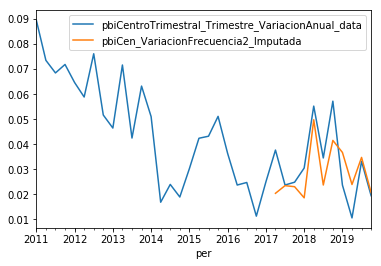

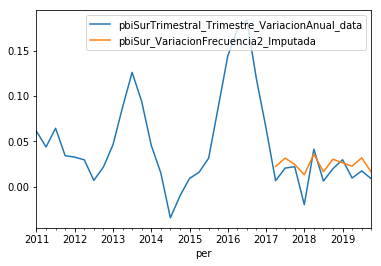

In [27]:
bd_eval = {}
models = {}
test_size_eval=36
for y in VariablesPBI:
    
    NombreVariableFrecuencia1Filtrada = y[0:6] + '_VariacionFrecuencia1_Filtrada'
    NombreVariableFrecuencia2Filtrada = y[0:6] + '_VariacionFrecuencia2_Filtrada'

    NombreVariableFrecuencia1Imputada = y[0:6] + '_VariacionFrecuencia1_Imputada'
    NombreVariableFrecuencia2Imputada = y[0:6] + '_VariacionFrecuencia2_Imputada'
    
    bd_pred_1s = pd.DataFrame()
    
    for test_size in range(test_size_eval,0,-1):

        BaseInterpolacion,_,_ = kalman_resultados(rutaEstimacion + 'ModelosKalman.xlsx', bd_all, y, frq1, frq2,test_size)

        if test_size>0:

            bd_pred = BaseInterpolacion[[y + '_data'] + [NombreVariableFrecuencia2Imputada]][-test_size:]
            bd_pred = bd_pred[bd_pred[y + '_data'] != 0].dropna()
            bd_pred = bd_pred[:1]
 
            if len(bd_pred.index.tolist())>0:
                if not(bd_pred.index[0] in bd_pred_1s.index):
                    bd_pred_1s = bd_pred_1s.append(bd_pred)
    
    bd_eval[y] = {'MAE': mean_absolute_error(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada]),
                    'R2': r2_score(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada]),
                    'RMSE': mean_squared_error(bd_pred_1s[y + '_data'],bd_pred_1s[NombreVariableFrecuencia2Imputada])**0.5
                   }
    
    BaseInterpolacion.loc[BaseInterpolacion[y + '_data'] != 0,[y + '_data']].join(bd_pred_1s.drop([y + '_data'], axis =1)).plot()
    
    plt.show()


In [28]:
pd.DataFrame(bd_eval).transpose()

,MAE,R2,RMSE
pbiCentroTrimestral_Trimestre_VariacionAnual,0.008400,0.413089,0.010393
pbiNorteTrimestral_Trimestre_VariacionAnual,0.020971,-1.331726,0.025936
pbiSurTrimestral_Trimestre_VariacionAnual,0.011486,0.123165,0.013977


### Model Checker

#### Importando modelos en forma de pandas

In [29]:
model = 1
VariablesPBI[model]

'pbiCentroTrimestral_Trimestre_VariacionAnual'

In [30]:
bd_model = pd.read_excel(rutaEstimacion + 'ModelosKalman.xlsx',sheet_name = VariablesPBI[model][0:20], index_col = 0 )

y = [VariablesPBI[model]]
X = bd_model.index[3:].tolist()

frq1 = 3
frq2 = 1

test_size=32

ParametrosOptimizados = bd_model.Valor.values.tolist()

In [31]:
bd_model

,Valor,STD,T
Phi,-0.287138,0.241974,-1.186648
Rho,0.144117,0.443411,0.325019
Sigma^2,0.000045,0.000028,1.570189
energiaNorte_Mensual_VariacionAnual,0.000000,0.044986,0.000000
energiaCentro_Mensual_VariacionAnual,0.128850,0.068626,1.877581
energiaSur_Mensual_VariacionAnual,0.000000,0.008430,0.000000
pbi_Mensual_VariacionAnual,0.285071,0.090041,3.165994


In [32]:
_, KalmanInterpolador, BaseInterpolacion = interpol(bd_all,X,y,frq1,frq2,ParametrosOptimizados,test_size)

### Interpolacion

###### Serie Usada

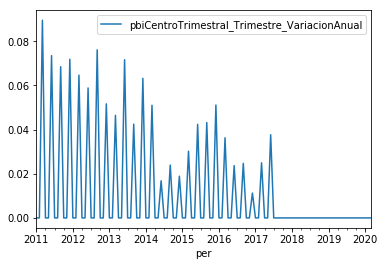

In [33]:
BaseInterpolacion[y].plot()

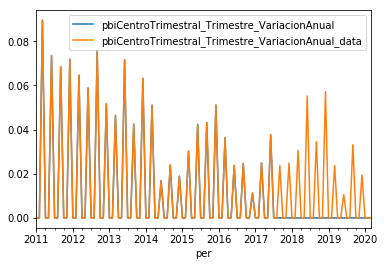

In [34]:
BaseInterpolacion[y + [y[0] + '_data']].plot()

In [35]:
NombreVariableFrecuencia1Filtrada = y[0][0:6] + '_VariacionFrecuencia1_Filtrada'
NombreVariableFrecuencia2Filtrada = y[0][0:6] + '_VariacionFrecuencia2_Filtrada'

NombreVariableFrecuencia1Imputada = y[0][0:6] + '_VariacionFrecuencia1_Imputada'
NombreVariableFrecuencia2Imputada = y[0][0:6] + '_VariacionFrecuencia2_Imputada'


BaseInterpolacion[NombreVariableFrecuencia1Filtrada] = pd.DataFrame(KalmanInterpolador.filter(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
BaseInterpolacion[NombreVariableFrecuencia2Filtrada] = BaseInterpolacion[NombreVariableFrecuencia1Filtrada].rolling(int(frq1/frq2)).mean()
BaseInterpolacion[NombreVariableFrecuencia1Imputada] = pd.DataFrame(KalmanInterpolador.smooth(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
BaseInterpolacion[NombreVariableFrecuencia2Imputada] = BaseInterpolacion[NombreVariableFrecuencia1Imputada].rolling(int(frq1/frq2)).mean()

###### Variables que interpolan

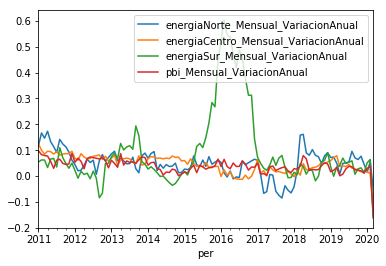

In [36]:
BaseInterpolacion[X].plot()

##### Interpolacion - Crecimiento Anual

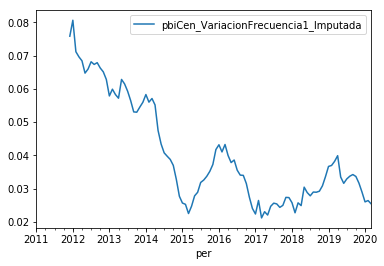

In [37]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada]].rolling(12).mean().plot()

###### Interpolacion - Baja frecuencia

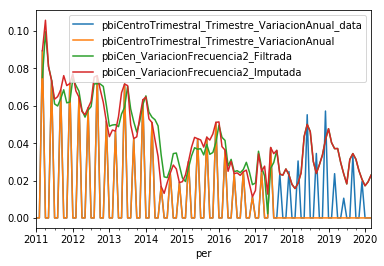

In [38]:
BaseInterpolacion[[y[0] + '_data'] + y + [NombreVariableFrecuencia2Filtrada,NombreVariableFrecuencia2Imputada]].plot()

###### Interpolacion - Alta frecuencia

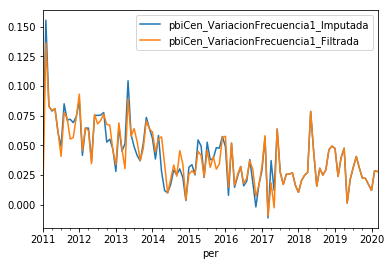

In [39]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia1Filtrada]].plot()

In [40]:
BaseInterpolacion[[NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia1Filtrada]][-12:]

,pbiCen_VariacionFrecuencia1_Imputada,pbiCen_VariacionFrecuencia1_Filtrada
per,,
2019-04-01,0.047680,0.047680
2019-05-01,0.001497,0.001497
2019-06-01,0.021519,0.021519
2019-07-01,0.031614,0.031614
2019-08-01,0.040695,0.040695
2019-09-01,0.030965,0.030965
2019-10-01,0.022549,0.022549
2019-11-01,0.022302,0.022302
2019-12-01,0.017125,0.017125


###### Correlaciones

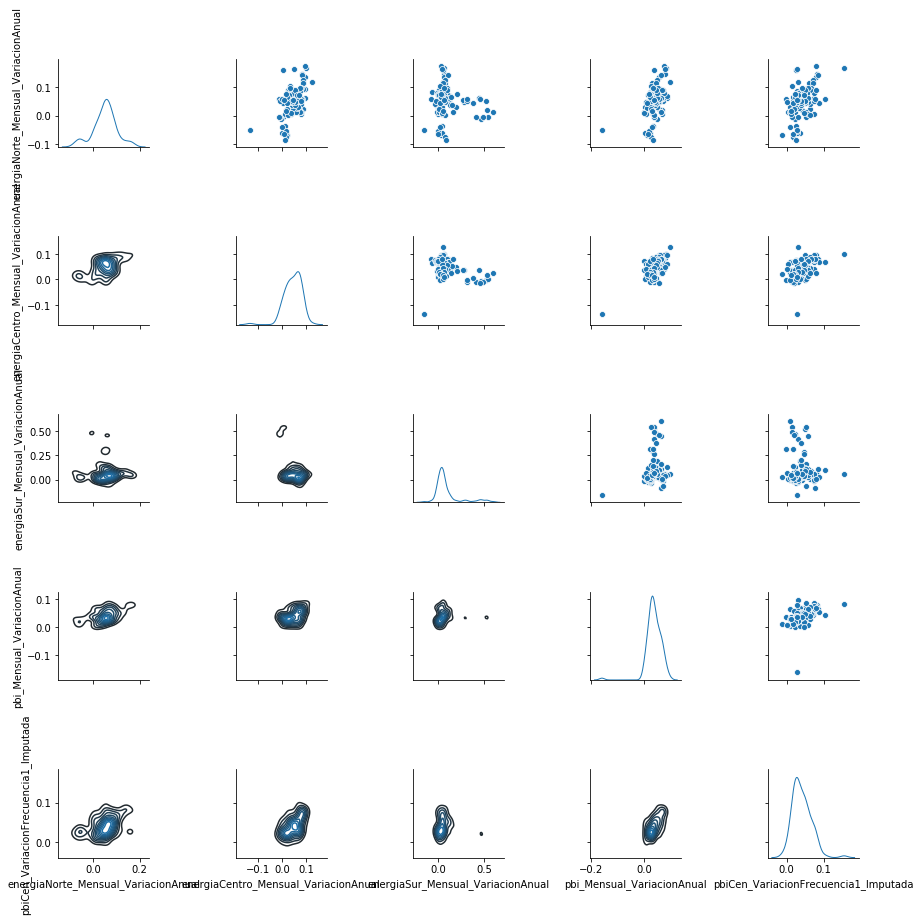

In [41]:
bd_temp = BaseInterpolacion[X + [NombreVariableFrecuencia1Imputada]]
g = sns.PairGrid(bd_temp)
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=1)